# Train Models

In [1]:
import random

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from dataset.ReferenceDataset import ReferenceDataset
from nets.SRGAN import Generator, Discriminator
from utils.vis import zoom_and_display_data
from utils.vis import visualize_data, visualize_images

# Transformations
from utils.process.corruption import Corruption


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

# Hyperparameters
BATCH_SIZE = 8
EPOCHS = 20
SCALE_FACTOR = 4  # Factor by which images are downscaled

torch.manual_seed(0)

NVIDIA GeForce RTX 4060 Laptop GPU


## Get Data

In [2]:
# Transform
corruptionTransform = transforms.Compose([Corruption(), transforms.ToTensor(),])

# Create datasets
pathToData = "C:\\Users\\neody\\Downloads\\img_celeba\\filtered"
corruptedDataset = ReferenceDataset(pathToData, transform=corruptionTransform, scale_factor=SCALE_FACTOR, imageSize=400)
regularDataset = ReferenceDataset(pathToData, scale_factor=SCALE_FACTOR, imageSize=400)

# Create dataloaders
testAndValProportion = 0.1
partition1 = int(len(regularDataset) * testAndValProportion)
partition2 = int(len(regularDataset) * 2 * testAndValProportion)

indicies = list(range(len(regularDataset)))
random.shuffle(indicies)

test_loader = DataLoader(regularDataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[:partition1]))
val_loader = DataLoader(regularDataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[partition1:partition2]))
train_loader = DataLoader(regularDataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(indicies[partition2:]))

print(f"Number of batches: {len(train_loader)}")

Number of batches: 1103


## Load Model

In [ ]:
from torchvision.models import vgg19, VGG19_Weights

vgg = vgg19(weights=VGG19_Weights.DEFAULT)
for i in list(vgg.features):
    print(i)

In [3]:
from torchvision.models import vgg19, VGG19_Weights

class ImageLoss(nn.Module):
    def __init__(self, cudaDevice):
        super(ImageLoss, self).__init__()
        self.mseLoss = nn.MSELoss()
        self.bceLoss = nn.BCELoss()
        
        vgg = vgg19(weights=VGG19_Weights.DEFAULT)
        self.vggFront = nn.Sequential(*list(vgg.features)[:31]).eval()
        for p in self.vggFront.parameters():
            p.requires_grad = False
        self.vggFront.to(cudaDevice)

    def forward(self, upscaled, high_res, predictedLabels, truthLabels):
        mse = self.mseLoss(upscaled, high_res)
        perception = self.mseLoss(self.vggFront(upscaled), self.vggFront(high_res))
        adversarial = self.bceLoss(predictedLabels, truthLabels)
        
        return mse + (0.001 * adversarial) + (0.006 * perception)

In [4]:
generator = Generator(doubling_number=2, B=6).to(device)
discriminator = Discriminator().to(device)

optimizerGenerator = optim.Adam(generator.parameters(), lr=1e-4)
optimizerDiscriminator = optim.Adam(discriminator.parameters(), lr=1e-4)

schedulerGenerator = torch.optim.lr_scheduler.StepLR(optimizerGenerator, step_size=10, gamma=0.1)
schedulerDiscriminator = torch.optim.lr_scheduler.StepLR(optimizerDiscriminator, step_size=10, gamma=0.1)

generatorLoss = ImageLoss(device)
discriminatorLoss = nn.BCELoss()

mseLoss = nn.MSELoss()

## Train Model

In [5]:
def validate(model, loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for low_res, high_res in loader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            running_loss += loss.item()
    return running_loss / len(loader)  # Return average loss

def vis(plt, train_losses, val_losses):
    # Plot the current loss values
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

In [16]:
low_res_test, high_res_test = regularDataset[4]
low_res_test = low_res_test.unsqueeze(0)
bicubic = nn.functional.interpolate(low_res_test, scale_factor=SCALE_FACTOR, mode='bicubic', align_corners=True)[0]

# Lists to store loss values for plotting
train_losses_G = []
train_losses_D = []
val_losses = []

# Training loop
for epoch in range(EPOCHS):
    
    generator.train() 
    discriminator.train()
    running_loss_G = 0.0
    running_loss_D = 0.0
    i = 0
    for low_res, high_res in train_loader:
        low_res, high_res = low_res.to(device), high_res.to(device)
        
        #Discriminator on real data
        Dout_real = discriminator(high_res)
        D_real_loss = discriminatorLoss(Dout_real, torch.ones(high_res.size()[0]).to(device))
      
        #Discriminator on fake data
        Dout_fake = discriminator(generator(low_res))
        D_fake_loss = discriminatorLoss(Dout_fake, torch.zeros(high_res.size()[0]).to(device))
        
        D_train_loss = D_real_loss + D_fake_loss
        optimizerDiscriminator.zero_grad()
        D_train_loss.backward()
        optimizerDiscriminator.step()
        running_loss_D += D_train_loss.data.item()
        
        #Generator
        G_out = generator(low_res)
        G_loss = generatorLoss(G_out, high_res, discriminator(G_out), torch.ones(high_res.size()[0]).to(device))
        optimizerGenerator.zero_grad()
        G_loss.backward()
        optimizerGenerator.step()
        running_loss_G += G_loss.data.item()
        
        #i += 1
        #if i % 100 == 0:
        #    print(i)
            
    train_losses_G.append(running_loss_G / len(train_loader)) 
    train_losses_D.append(running_loss_D / len(train_loader))
    
    
    val_loss = validate(generator, val_loader, mseLoss, device)

   
    val_losses.append(val_loss)
    schedulerDiscriminator.step()
    schedulerGenerator.step()
    # Beautified print statement with 5 decimal points
    print(f"Epoch ({epoch+1}/{EPOCHS}), Discriminator Loss: [{train_losses_D[-1]:.6f}], Generator Loss: [{train_losses_G[-1]:.6f}], Val Loss: [{val_loss:.6f}]")


    
    output = generator(low_res_test)
    up_res = output.squeeze(0).cpu().detach()
    visualize_images(bicubic, up_res, high_res_test)


100
200
300
400
500
600
700
800
900
1000
1100
Epoch (1/20), Discriminator Loss: [0.917292], Generator Loss: [0.011867], Val Loss: [0.002372]
100
200
300
400
500
600
700
800
900
1000
1100
Epoch (2/20), Discriminator Loss: [1.014069], Generator Loss: [0.010475], Val Loss: [0.002250]
100
200
300
400
500
600
700
800
900
1000
1100
Epoch (3/20), Discriminator Loss: [0.947558], Generator Loss: [0.009891], Val Loss: [0.002332]
100
200
300
400
500
600
700
800
900
1000
1100
Epoch (4/20), Discriminator Loss: [0.773921], Generator Loss: [0.010112], Val Loss: [0.001956]
100
200
300
400
500
600
700
800
900
1000
1100
Epoch (5/20), Discriminator Loss: [0.198422], Generator Loss: [0.012434], Val Loss: [0.002565]
100
200
300
400
500
600
700
800
900
1000
1100
Epoch (6/20), Discriminator Loss: [0.444442], Generator Loss: [0.012112], Val Loss: [0.001982]
100
200
300
400
500
600
700
800
900
1000
1100
Epoch (7/20), Discriminator Loss: [0.529333], Generator Loss: [0.011785], Val Loss: [0.002095]
100
200
300
4

KeyboardInterrupt: 

torch.Size([3, 400, 400])
torch.Size([3, 400, 400])
torch.Size([3, 400, 400])


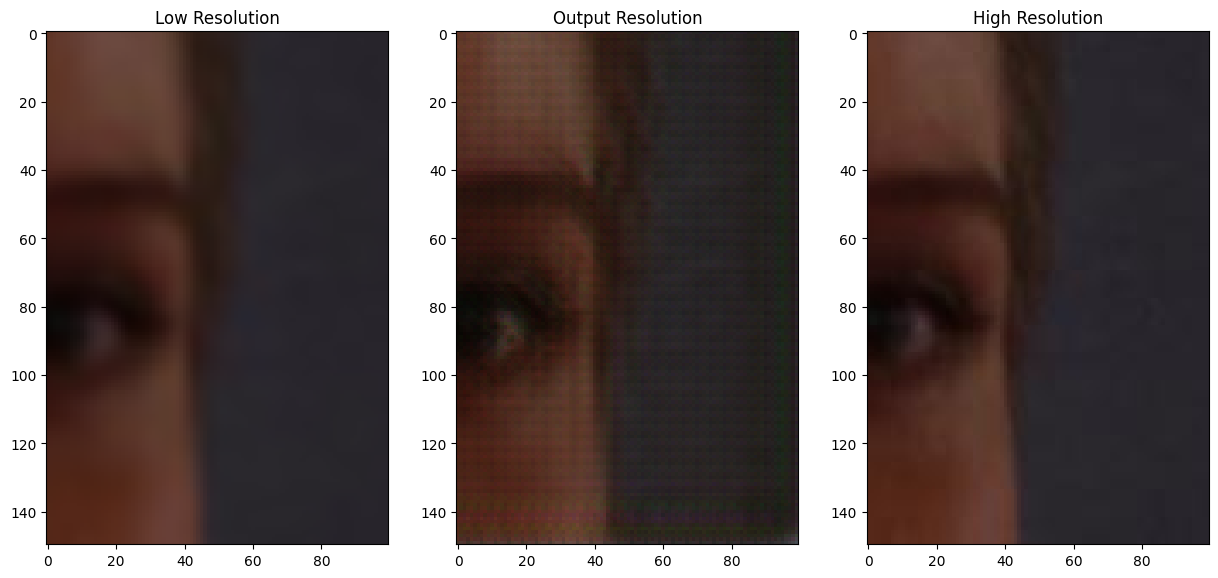

In [15]:
low_res, high_res = regularDataset[4]
low_res = low_res.unsqueeze(0)
low_res = low_res.to(device)
high_res = high_res.to(device)
bicubic = nn.functional.interpolate(low_res, scale_factor=SCALE_FACTOR, mode='bicubic', align_corners=True)[0]

output = generator(low_res)

up_res = output.squeeze(0).cpu().detach()
print(bicubic.size())
print(up_res.size())
print(high_res.size())
visualize_images(bicubic.cpu()[:, 250:450, 300:500], up_res.cpu()[:, 250:450, 300:500], high_res.cpu()[:, 250:450, 300:500])

## Save Model

In [17]:
# Save the model
nameG = f"./models/{generator.__class__.__name__}~{EPOCHS}_{SCALE_FACTOR}_{BATCH_SIZE}_G.pth"
torch.save(generator.state_dict(), nameG)
nameD = f"./models/{discriminator.__class__.__name__}~{EPOCHS}_{SCALE_FACTOR}_{BATCH_SIZE}_D.pth"
torch.save(discriminator.state_dict(), nameD)

In [ ]:
# Plot the current loss values
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

## Visualize Model

In [34]:
randomize_idx = True  # Set to False to disable randomization
random_index = random.randint(0, len(regularDataset) - 1) if randomize_idx else 0
print(f"Random index: {random_index}")
low_res, high_res = regularDataset[random_index]
print(low_res.shape, high_res.shape)
low_res = low_res.unsqueeze(0)


Random index: 10492
torch.Size([3, 100, 100]) torch.Size([3, 400, 400])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 400, 400])
torch.Size([3, 400, 400])
torch.Size([3, 400, 400])


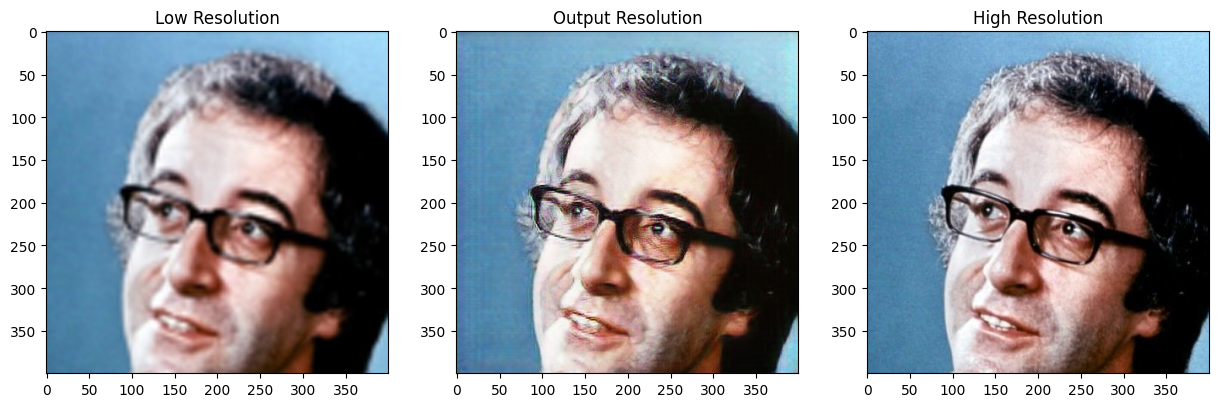

In [35]:

output = generator(low_res.to(device))
up_res = output.squeeze(0).cpu().detach()

bicubic = nn.functional.interpolate(low_res, scale_factor=4, mode='bicubic', align_corners=True)[0]
print(bicubic.shape)
print(up_res.shape)
print(high_res.shape)
visualize_images(bicubic, up_res, high_res)

In [28]:
from utils.vis import calculate_point
def zoom(low_res, up_res, high_res, scale_factor, num_zooms, randomize_point=True):
    hr_height, hr_width = high_res.shape[-2], high_res.shape[-1]
    
    # Calculate random or fixed point for zooming
    zoom_point_x, zoom_point_y = calculate_point((hr_height, hr_width), randomize_point)

    # Ensure zoom window maintains aspect ratio
    hr_aspect_ratio = hr_width / hr_height

    # Iterate through zoom levels
    for zoom_level in range(num_zooms):
        # Calculate zoom window size, maintaining aspect ratio
   

        hr_zoom_window_width = int(hr_width // (2 ** zoom_level))
        hr_zoom_window_height = int(hr_zoom_window_width / hr_aspect_ratio)



        # Calculate corresponding coordinates for high-resolution and upscaled images
        hr_end_x = min(zoom_point_x + hr_zoom_window_width, hr_width)
        hr_end_y = min(zoom_point_y + hr_zoom_window_height, hr_height)

        # Plotting the images
        plt.figure(figsize=(15, 15))

        # Low-resolution image
        plt.subplot(1, 3, 1)
        plt.title(f'Low Resolution (Zoom Level {zoom_level + 1})')
        plt.imshow(low_res.permute(1, 2, 0)[zoom_point_y:hr_end_y, zoom_point_x:hr_end_x, :])

        # Upscaled image
        plt.subplot(1, 3, 2)
        plt.title(f'Upscaled Resolution (Zoom Level {zoom_level + 1})')
        plt.imshow(up_res.permute(1, 2, 0)[zoom_point_y:hr_end_y, zoom_point_x:hr_end_x, :])

        # High-resolution image
        plt.subplot(1, 3, 3)
        plt.title(f'High Resolution (Zoom Level {zoom_level + 1})')
        plt.imshow(high_res.permute(1, 2, 0)[zoom_point_y:hr_end_y, zoom_point_x:hr_end_x, :])

        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


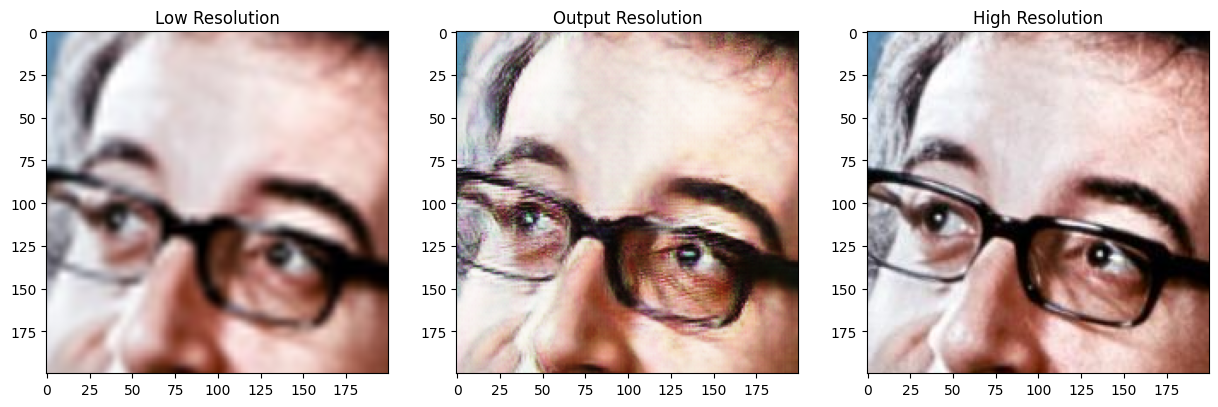

In [36]:
# Parameters
randomize_point = True
num_zooms = 4  # Hyperparameter for number of zooms

# Zoom and display images
#zoom(bicubic, up_res, high_res, SCALE_FACTOR, num_zooms, randomize_point)
pointX = 100
pointY = 100
scale = 200
visualize_images(bicubic[:, pointY:pointY + scale, pointX:pointX + scale], up_res[:, pointY:pointY + scale, pointX:pointX + scale], high_res[:, pointY:pointY + scale, pointX:pointX + scale])